### 1 Import library

In [26]:
import cv2
import numpy as np
import skimage.io as io
import os as os
import skimage.util as util
import matplotlib.pyplot as plt
import skimage.filters as filt


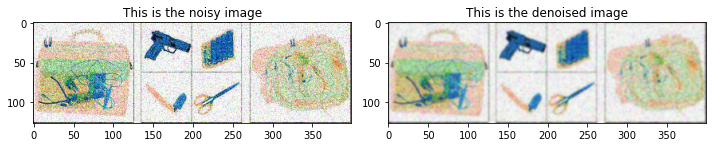

In [24]:
noisy_image = io.imread("noisy images/im_13.jpg")
# denoised_image = vector_median(noisy_image, 1)

 # gaussian filter
denoised_image = filt.gaussian(noisy_image, sigma = 1, multichannel=True)
denoised_image = util.img_as_ubyte(denoised_image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(noisy_image)
ax[0].set_title("This is the noisy image")
ax[1].imshow(denoised_image)
ax[1].set_title("This is the denoised image")

fig.tight_layout()
plt.show()

### 2 load Image and enhancement

In [31]:

enhanced_image_list = {}

for root, dirs, files in os.walk('noisy images'):
    for filename in files:
        # construct the full filename
        fname = os.path.join(root, filename)
        
        
        # In case these metadata files show up in the folders, ignore them.

        if filename == '.DS_Store':   
            continue
        
      
        
        noisy_image = io.imread(fname)

        # gaussian filter
        denoised_image = filt.gaussian(noisy_image, sigma = 1, multichannel=True)
        denoised_image = util.img_as_ubyte(denoised_image)

        enhanced_image_list[filename[:-4]+'.jpg'] = denoised_image


        io.imsave(os.path.join('denoised images', filename[:-4]+'.jpg'), denoised_image)
        

### 3 load trained model

In [35]:

net = cv2.dnn.readNet('yolov3_training_last.weights', 'yolov3_testing.cfg')

### 4 Object detection and classifcation

In [36]:
classes = []
with open("classes.txt", "r") as f:
    classes = f.read().splitlines()

font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(100, 3))


In [37]:
for filename in enhanced_image_list : 
    #_, img = cap.read()
    # img = cv2.imread("test_images/im_8.jpg")

    img = enhanced_image_list[filename]
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    if len(indexes)>0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = colors[i]
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            cv2.putText(img, label + " " + confidence, (x, y+20), font, 1, (255,255,255), 2)


    #Storing the image
    cv2.imwrite('Predicted output/'+filename + '.jpg', img)
   
cv2.destroyAllWindows()